# Imports

Packages and dependencies

In [10]:
from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

In [11]:
from src.models import *
from src.functions import *
from src.data import *
from src.rvae import *
from src.trainer import *
from src.classifier import *
from src.steps import *
from src.similarity import *

In [12]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)

In [14]:
fashionmnist_trainset = datasets.FashionMNIST('data/FashionMNIST/', train=True, download=True)
fashionmnist_testset = datasets.FashionMNIST('data/FashionMNIST/', train=False, download=True)

In [15]:
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.device_count())

True
1.12.0+cu113
8


# Transforming Dataset 

Here you can see some examples of using the ```get_mnist_data()``` function and its output. Feel free to play around with parameters such as ```coord```, ```rotation_range```, ```translation_range```, and ```digits```. The source is found in ```src/data.py```.

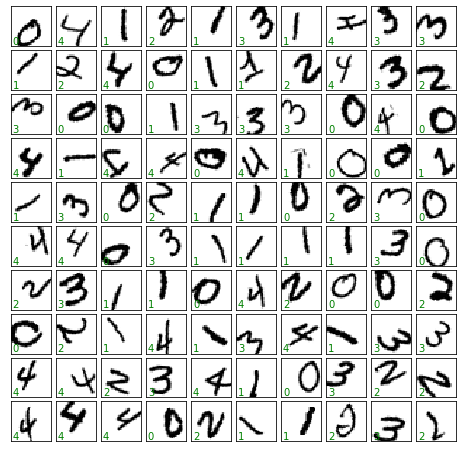

In [34]:
train_data, train_labels, angles, translations = get_mnist_data(
    mnist_trainset, 
    digits = [0,1,2,3,4],
    coord = 3
    )

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

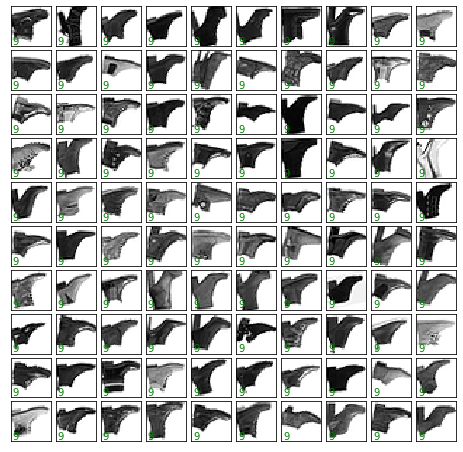

In [37]:
train_data, train_labels, angles, translations = get_mnist_data(
    fashionmnist_trainset, 
    digits = [9],
    rotation_range = [160, 201]
    )

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

# Training Models

In this section we trained over 120 models using the convenience function ```train_vae()``` found in ```src/steps.py```. 

We use a naming convention to store and access our saved models. For example:
* ```saved_models/1_0_7.pkl``` - Using rotated data (1), training a vanilla VAE (4), on labels 0-7 in MNIST
* ```saved_models/f2_3_4.pkl``` - Using translated data (2), training a rotation + translation invariant VAE (3), on labels 0-4 in FashionMNIST (f)

### Trained MNIST Models

First we train all four models on all three types of transformed data on half the classes for our ROC curves. 

In [23]:
# Train on half of labels for ROC curves

# j = data_coord
# i = model_coord

# each model saved to 'saved_models/j_i_4.pkl'

for j in [1,2,3]:
    for i in [0,1,2,3]:
        continue
        train_vae(mnist_trainset, f'{j}_{i}_4', j, i, [0,1,2,3,4])

Then we train two models (vanilla and one of the invariants) on all three types of transformed data, on all numbers of classes for our AUC bar graphs.

In [24]:
# Train on varying number of labels for bar graphs

# j = data_coord
# i = model_coord
# k = maximum label trained on (skipping 4 since we already trained those above)

# each model saved to 'saved_models/j_i_k.pkl'

labels = [0,1,2,3,4,5,6,7,8,9]

for j in [1,2,3]:
    for i in [0,j]:
        for k in [0,1,2,3,5,6,7,8,9]:
            continue
            train_vae(mnist_trainset, f'{j}_{i}_{k}', j, i, labels[:k+1])

### Trained FashionMNIST Models

We do the same with the FashionMNIST dataset.

In [25]:
# Train on half of labels for ROC curves

# j = data_coord
# i = model_coord

# each model saved to 'saved_models/fj_i_4.pkl'

for j in [1,2,3]:
    for i in [0,1,2,3]:
        continue
        train_vae(fashionmnist_trainset, f'f{j}_{i}_4', j, i, [0,1,2,3,4])

In [26]:
# Train on varying number of labels for bar graphs

# j = data_coord
# i = model_coord
# k = maximum label trained on (skipping 4 since we already trained those above)

# each model saved to 'saved_models/fj_i_k.pkl'

labels = [0,1,2,3,4,5,6,7,8,9]

for j in [1,2,3]:
    for i in [0,j]:
        for k in [0,1,2,3,5,6,7,8,9]:
            continue
            train_vae(fashionmnist_trainset, f'{j}_{i}_{k}', j, i, labels[:k+1])

# Pair Matching

### ROC for MNIST

Here we test 'same/different' pair classification using cosine similarity of latent encodings. Labels 0-4 are used for training and labels 5-9 are used for testing. The four VAE models are trained and tested on three different types of transformed data. In each of the three scenarios, the corresponding invariant VAE performs the best. Notice that the Rot+Trans Invariant VAE (RTInv) also performs well in the first two scenarios.

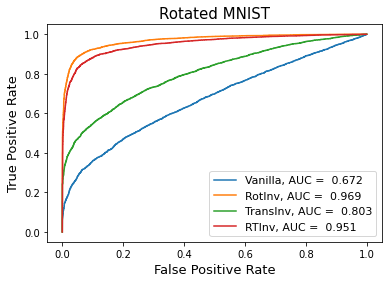

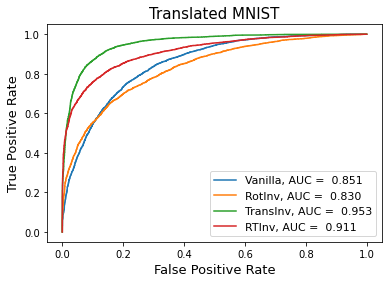

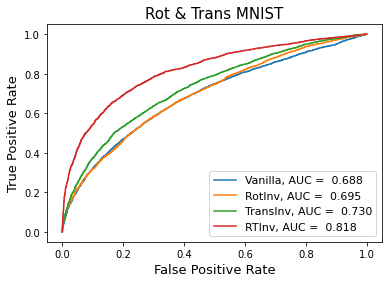

In [56]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,1,2,3]:  
        vae = load_vae(f'{j}_{i}_4', i)
        auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [5,6,7,8,9], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'{dataname[j]} MNIST', fontsize = 15)
    plt.show()

### ROC for FashionMNIST

We perform the same tests on FashionMNIST. There are similar results for rotated data and translated data, but with less of a difference in performance. For the rotated and translated data, the TransInv VAE performs the best and the RTInv actually performs the worst. This may be due to the more complex nature of the FashionMNIST dataset, and how the data is prepared. 

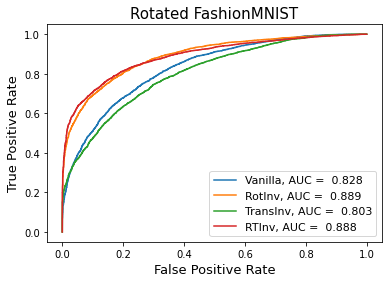

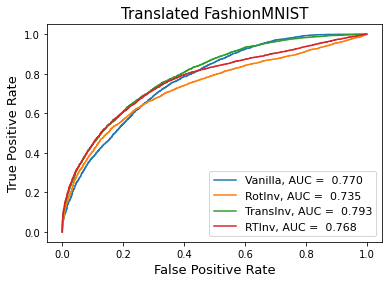

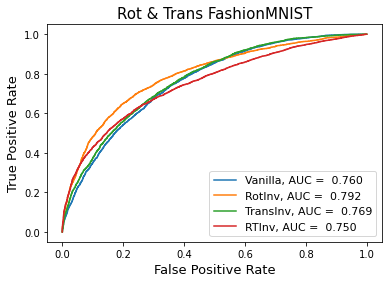

In [16]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,1,2,3]:  
        vae = load_vae(f'f{j}_{i}_4', i)
        auc, fpr, tpr, thresholds = pair_matching(fashionmnist_testset, [5,6,7,8,9], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'{dataname[j]} FashionMNIST', fontsize = 15)
    plt.show()

### ROC for MNIST tested on FashionMNIST

Here we evaluate pair matching using models trained on all MNIST labels and test them on all FashionMNIST labels. In each of three settings of transformed data, we compare the vanilla VAE to the corresponding invariant VAE, which is seen to always perform better.

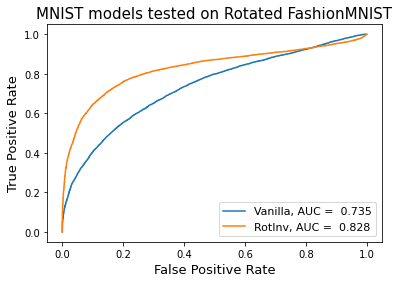

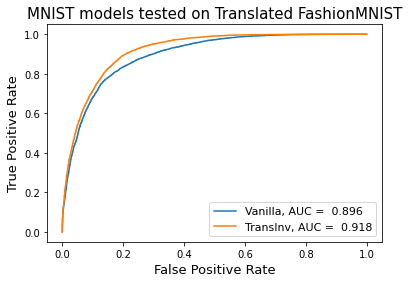

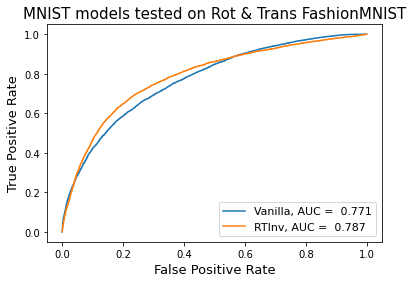

In [31]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,j]:  
        vae = load_vae(f'{j}_{i}_9', i)
        auc, fpr, tpr, thresholds = pair_matching(fashionmnist_testset, [0,1,2,3,4,5,6,7,8,9], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'MNIST models tested on {dataname[j]} FashionMNIST', fontsize = 15)
    plt.show()

### ROC for FashionMNIST tested on MNIST

We do the same tests as above, but instead train on FashionMNIST and test on MNIST. The invariant VAE again outperforms the vanilla VAE, but by a much narrower margin.

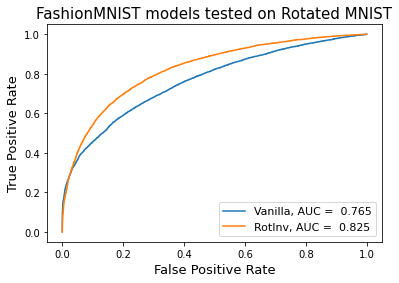

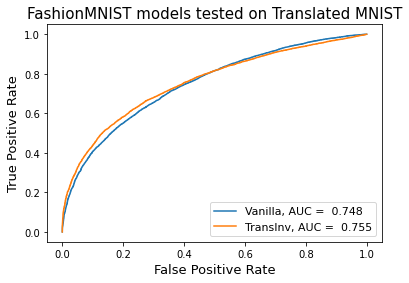

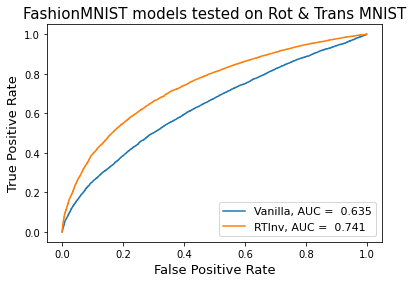

In [32]:
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

for j in [1,2,3]:
    plt.axes()
    for i in [0,j]:  
        vae = load_vae(f'f{j}_{i}_9', i)
        auc, fpr, tpr, thresholds = pair_matching(mnist_testset, [0,1,2,3,4,5,6,7,8,9], vae, j)
        plt.plot(fpr, tpr, label = f'{vaename[i]}, AUC = {auc: .3f}')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.title(f'FashionMNIST models tested on {dataname[j]} MNIST', fontsize = 15)
    plt.show()

### AUC by classes trained for MNIST

Here we plot the area under the ROC curve (AUC) across varying number of training classes. In each of the three settings of transformed data, we compare the vanilla VAE to the corresponding invariant VAE, which consistently performs better.

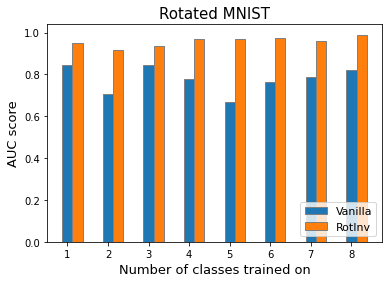

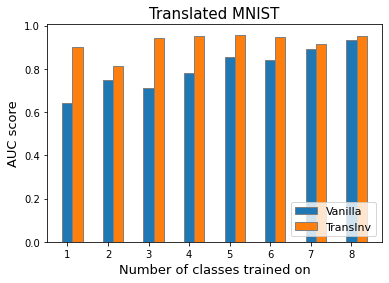

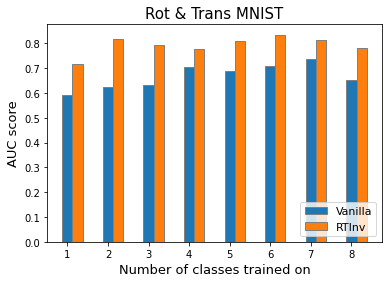

In [57]:
labels = range(10)
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

barWidth = 0.25
br1 = range(1, 9)
br2 = [x + barWidth for x in br1]

for j in [1,2,3]:
    vae_scores = []
    inv_scores = []

    for i in range(8):
        vae = load_vae(f'{j}_0_{i}', 0)
        score = pair_matching(mnist_testset, labels[i+1:], vae, j)[0]
        vae_scores.append(score)

        inv = load_vae(f'{j}_{j}_{i}', j)
        score = pair_matching(mnist_testset, labels[i+1:], inv, j)[0]
        inv_scores.append(score)


    plt.axes()
    plt.bar(br1, vae_scores, width = barWidth, label = vaename[0], edgecolor = 'grey')
    plt.bar(br2, inv_scores, width = barWidth, label = vaename[j], edgecolor = 'grey')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('Number of classes trained on', fontsize = 13)
    plt.ylabel('AUC score', fontsize = 13)
    plt.title(f'{dataname[j]} MNIST', fontsize = 15)
    plt.show()

### AUC by classes trained for FashionMNIST

We repeat the same tests for FashionMNIST, getting similar results with a much narrower margin.

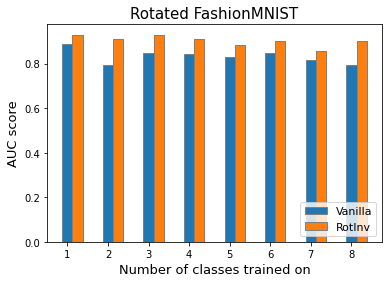

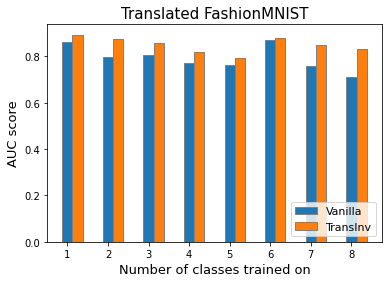

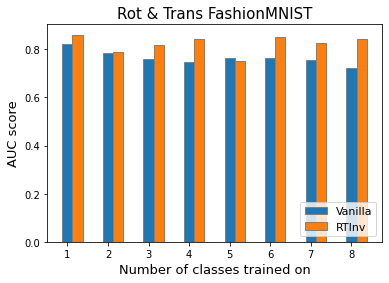

In [27]:
labels = range(10)
vaename = {0: "Vanilla", 1: "RotInv", 2: "TransInv", 3: "RTInv"}
dataname = {1: "Rotated", 2: "Translated", 3: "Rot & Trans"}

barWidth = 0.25
br1 = range(1, 9)
br2 = [x + barWidth for x in br1]

for j in [1,2,3]:
    vae_scores = []
    inv_scores = []

    for i in range(8):
        vae = load_vae(f'f{j}_0_{i}', 0)
        score = pair_matching(fashionmnist_testset, labels[i+1:], vae, j)[0]
        vae_scores.append(score)

        inv = load_vae(f'f{j}_{j}_{i}', j)
        score = pair_matching(fashionmnist_testset, labels[i+1:], inv, j)[0]
        inv_scores.append(score)


    plt.axes()
    plt.bar(br1, vae_scores, width = barWidth, label = vaename[0], edgecolor = 'grey')
    plt.bar(br2, inv_scores, width = barWidth, label = vaename[j], edgecolor = 'grey')

    plt.legend(loc='lower right', fontsize=11)
    plt.xlabel('Number of classes trained on', fontsize = 13)
    plt.ylabel('AUC score', fontsize = 13)
    plt.title(f'{dataname[j]} FashionMNIST', fontsize = 15)
    plt.show()

### Sample Heatmap

Heatmap plotting of cosine similarity for samples. In this example you can see that RotInvVAE trained on MNIST 1-5 has high cosine similarity for same labels in MNIST 5-9.

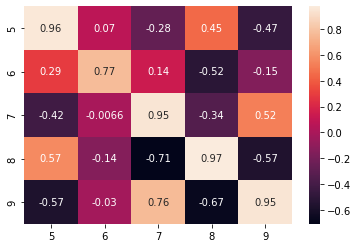

In [63]:
vae = load_vae('1_1_4', 1)
plot_sample_heatmap(mnist_testset, [5,6,7,8,9], vae, 1, n_samples = 1, annot = True)